In [292]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization,Conv2D, MaxPooling2D


#import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10  # библиотека базы выборок cifar10  

In [293]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

for i in range(len(y_train)):
    if y_train[i][0] != 5 and y_train[i][0] != 3:
        y_train[i] = 0 # ничего
    if y_train[i][0] == 5:  
        y_train[i] = 1 # собаки
    if y_train[i][0] == 3:  
        y_train[i] = 2 # кошки
    
for i in range(len(y_test)):
    if y_test[i][0] != 5 and y_test[i][0] != 3:
        y_test[i] = 0
    if y_test[i][0] == 5: 
        y_test[i] = 1
    if y_test[i][0] == 3:  
        y_test[i] = 2

# стандартизация входных данных
x_train = x_train / 255
x_test = x_test / 255

y_train_cat = keras.utils.to_categorical(y_train, 3)
y_test_cat = keras.utils.to_categorical(y_test, 3)
"""
def preprocess (image, label):
    return tf.image.resize(image, [200, 200])/255, label

split = ["train[:80%]", "train[80%:]"] # объект, который разделяет датасеты

(ds_train, ds_test), ds_info = tfds.load(name = "cats_vs_dogs", split = split, as_supervised = True, with_info = True)

ds_train = ds_train.map(preprocess).batch(500)
ds_test = ds_test.map(preprocess).batch(500)

#x_train = np.expand_dims(x_train, axis=3)
#x_test = np.expand_dims(x_test, axis=3)
"""

'\ndef preprocess (image, label):\n    return tf.image.resize(image, [200, 200])/255, label\n\nsplit = ["train[:80%]", "train[80%:]"] # объект, который разделяет датасеты\n\n(ds_train, ds_test), ds_info = tfds.load(name = "cats_vs_dogs", split = split, as_supervised = True, with_info = True)\n\nds_train = ds_train.map(preprocess).batch(500)\nds_test = ds_test.map(preprocess).batch(500)\n\n#x_train = np.expand_dims(x_train, axis=3)\n#x_test = np.expand_dims(x_test, axis=3)\n'

In [294]:
print( x_train.shape )

(50000, 32, 32, 3)


Вариант с  тремя сверточными слоями: 

In [307]:
model = keras.Sequential([
    Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),
    Flatten(),
    Dense(256, activation='relu'),
    #Dropout(0.5),
    #BatchNormalization(),
    Dense(3,  activation='softmax')
])

In [308]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
#categorical

Epoch 1/5
625/625 [==============================] - 30s 48ms/step - loss: 0.5038 - accuracy: 0.8152 - val_loss: 0.4481 - val_accuracy: 0.8262
Epoch 2/5
625/625 [==============================] - 34s 55ms/step - loss: 0.4257 - accuracy: 0.8369 - val_loss: 0.4107 - val_accuracy: 0.8406
Epoch 3/5
625/625 [==============================] - 31s 49ms/step - loss: 0.3906 - accuracy: 0.8508 - val_loss: 0.4084 - val_accuracy: 0.8423
Epoch 4/5
625/625 [==============================] - 28s 45ms/step - loss: 0.3661 - accuracy: 0.8592 - val_loss: 0.3867 - val_accuracy: 0.8491
Epoch 5/5
625/625 [==============================] - 30s 48ms/step - loss: 0.3408 - accuracy: 0.8693 - val_loss: 0.3753 - val_accuracy: 0.8569


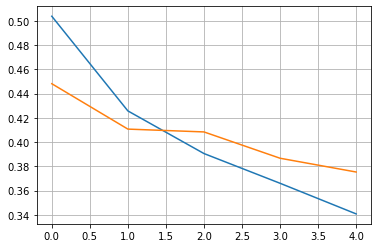

In [309]:
his = model.fit(x_train, y_train_cat, batch_size=64, epochs=5, validation_split=0.2)

plt.plot(his.history['loss']) # 2й history - словарь, loss - критерий качества
#, вычисленный для каждой эпохи
plt.plot(his.history['val_loss'])
plt.grid(True)
plt.show()

In [310]:
model.evaluate(x_test, y_test_cat)

313/313 [==============================] - 2s 5ms/step - loss: 0.3689 - accuracy: 0.8603


[0.36888760328292847, 0.8603000044822693]

Проведем анализ:

In [311]:
# Распознавание всей тестовой выборки
pred = model.predict(x_test) # 10000 векторов из 10 значений
pred = np.argmax(pred, axis=1) # 10000 значений, которые являются числом

new_y = []
for i in range(len(y_test)):
    new_y.append(int(y_test[i][0]))
    
#del y_test
#print(new_y)  

print(pred.shape)

print(pred[:20]) # первые 20 предсказанных чисел
print(new_y[:20]) # реальные первые 20 чисел

(10000,)
[1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0]
[2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]


In [313]:
# Выделение неверных вариантов
mask = pred == new_y # формируем маску. Где сравненные значения равны -> True
# если не равны -> False
print(mask[:10]) #

x_false = x_test[~mask] # только те, что со значением false
p_false = pred[~mask]

print(x_false.shape)

[False  True  True  True  True  True  True  True  True  True]
(1397, 32, 32, 3)


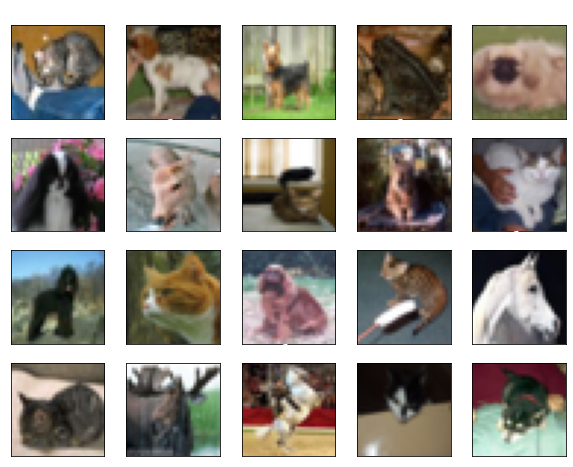

In [314]:
# Вывод первых 20 неверных результатов
class_name = ["Ничего","Собака","Кошка"]
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(class_name[p_false[i]], color = 'white', size = 15)
    plt.imshow(x_false[i], cmap=plt.cm.binary)

plt.show()

Вариант с одним сверточным слоем: 

In [315]:
model = keras.Sequential([
    Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2), strides=2),
    Flatten(),
    Dense(256, activation='relu'),
    #Dropout(0.5),
    #BatchNormalization(),
    Dense(3,  activation='softmax')
])

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

Epoch 1/5
625/625 [==============================] - 13s 20ms/step - loss: 0.5065 - accuracy: 0.8139 - val_loss: 0.4772 - val_accuracy: 0.8232
Epoch 2/5
625/625 [==============================] - 16s 25ms/step - loss: 0.4352 - accuracy: 0.8322 - val_loss: 0.4489 - val_accuracy: 0.8293
Epoch 3/5
625/625 [==============================] - 17s 27ms/step - loss: 0.4034 - accuracy: 0.8454 - val_loss: 0.4337 - val_accuracy: 0.8324
Epoch 4/5
625/625 [==============================] - 16s 25ms/step - loss: 0.3744 - accuracy: 0.8567 - val_loss: 0.4190 - val_accuracy: 0.8384
Epoch 5/5
625/625 [==============================] - 16s 25ms/step - loss: 0.3488 - accuracy: 0.8668 - val_loss: 0.4097 - val_accuracy: 0.8389


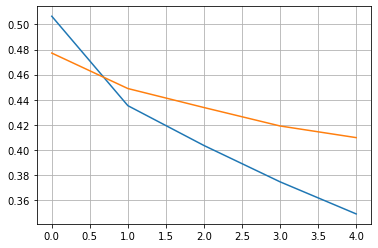

In [316]:
his = model.fit(x_train, y_train_cat, batch_size=64, epochs=5, validation_split=0.2)

plt.plot(his.history['loss']) # 2й history - словарь, loss - критерий качества
#, вычисленный для каждой эпохи
plt.plot(his.history['val_loss'])
plt.grid(True)
plt.show()